In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Time Series Analysis
We initally intended to run a time series analysis on the data. However, we were
not confident in the results. Therefore, we stopped working on it. We decided
not to delete this notebook, as our work on time series analysis was a good
learning experience and we might come back to this notebook in the future.  

In [49]:
trips_df = pd.read_pickle('../00_data/trips_hourly_selected.pkl')

In [50]:
demand = trips_df['starting_trips']
demand.head(2)

index
2019-01-01 01:00:00     8.0
2019-01-01 02:00:00    11.0
Name: starting_trips, dtype: float64

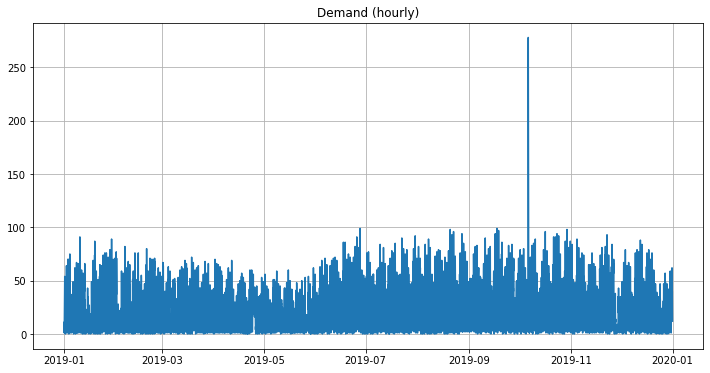

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(demand)
plt.title("Demand (hourly)")
plt.grid(True)
plt.show()

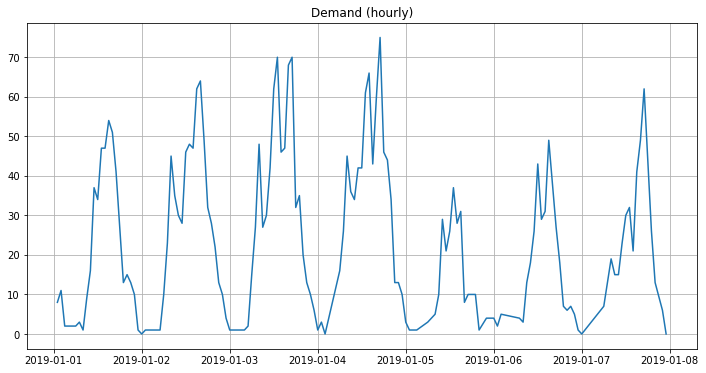

In [52]:
demand_first_week = demand[demand.index < '2019-01-8']
plt.figure(figsize=(12, 6))
plt.plot(demand_first_week)
plt.title("Demand (hourly)")
plt.grid(True)
plt.show()

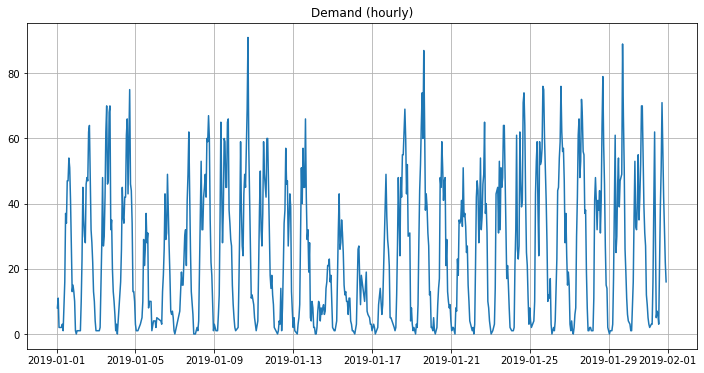

In [53]:
demand_january = demand[demand.index.month == 1]
plt.figure(figsize=(12, 6))
plt.plot(demand_january)
plt.title("Demand (hourly)")
plt.grid(True)
plt.show()

In [54]:
demand_train = demand_january
# use next day as test set
last_demand_january_index = demand_january.index.max()
demand_test = demand[last_demand_january_index + timedelta(hours=1): last_demand_january_index + timedelta(hours=24)]

In [55]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
    Disclaimer: This function has been taken and modified from the following link:
    https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

    Plot time series, its ACF and PACF, calculate Dickey–Fuller test

    y - timeseries
    lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Dickey-Fuller: p={0:.5f}".format(p_value))

        upper_bound = 1.96 / np.sqrt(len(y))
        lower_bound = -1.96 / np.sqrt(len(y))

        lag_acf = smt.acf(y, nlags=lags)
        acf_ax.plot(lag_acf, label="Autocorrelation")
        acf_ax.axhline(y=0, linestyle="--", color="gray")
        acf_ax.axhline(y=lower_bound, linestyle="--", color="gray")
        acf_ax.axhline(y=upper_bound, linestyle="--", color="gray")
        acf_ax.set_title("ACF")

        lag_pacf = smt.pacf(y, nlags=lags, method="ols")
        pacf_ax.plot(lag_pacf, label="Partial Autocorrelation")
        pacf_ax.axhline(y=0, linestyle="--", color="gray")
        pacf_ax.axhline(y=lower_bound, linestyle="--", color="gray")
        pacf_ax.axhline(y=upper_bound, linestyle="--", color="gray")
        pacf_ax.set_title("PACF")

        acf_lag_value_crossing_upper_bound = np.argmax(lag_acf < upper_bound)
        pacf_lag_value_crossing_upper_bound = np.argmax(lag_pacf < upper_bound)
        print("ACF lag value crossing upper bound: {0}".format(acf_lag_value_crossing_upper_bound))
        print("PACF lag value crossing upper bound: {0}".format(pacf_lag_value_crossing_upper_bound))
        plt.tight_layout()


ACF lag value crossing upper bound: 6
PACF lag value crossing upper bound: 2


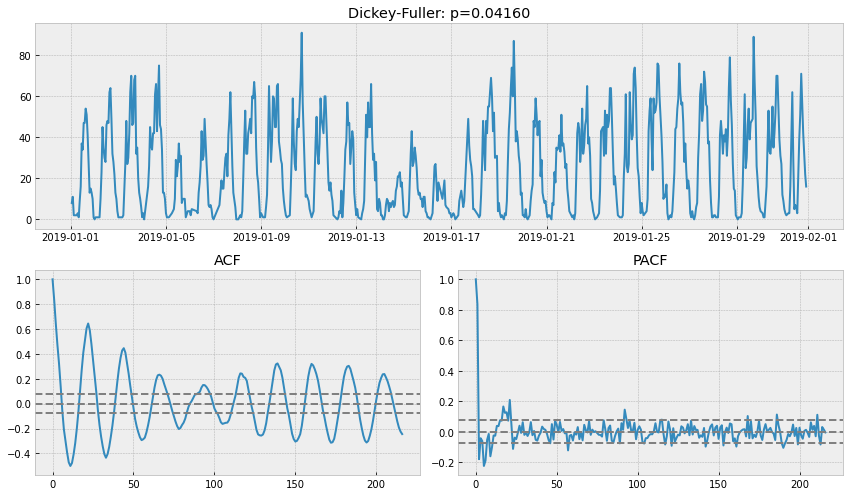

In [56]:
tsplot(demand_train, lags=24 * 9)

ACF lag value crossing upper bound: 5
PACF lag value crossing upper bound: 2


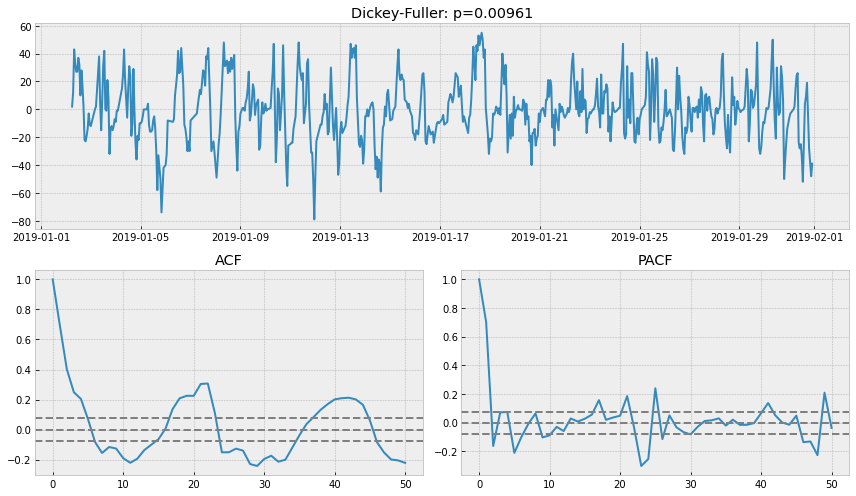

In [57]:
demand_diff_daily = demand_train - demand_train.shift(24)
demand_diff_daily = demand_diff_daily.dropna()
tsplot(demand_diff_daily, lags=50)

ACF lag value crossing upper bound: 1
PACF lag value crossing upper bound: 1


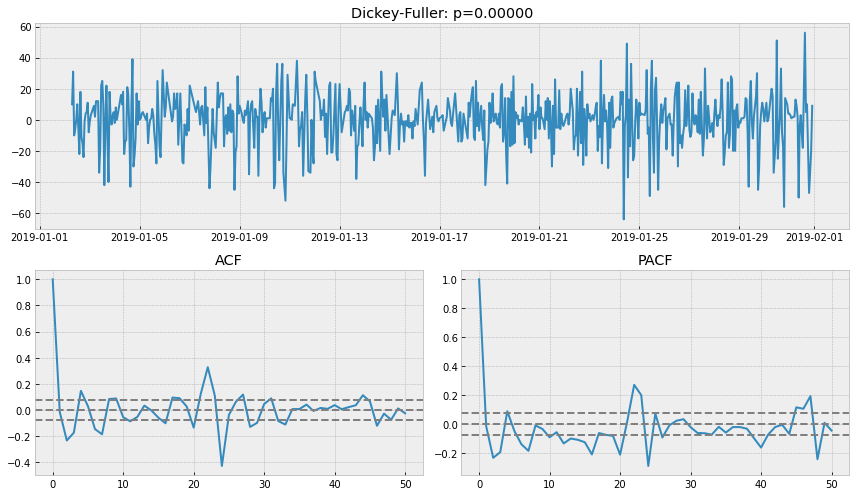

In [58]:
demand_diff = demand_diff_daily - demand_diff_daily.shift(1)
demand_diff = demand_diff.dropna()
tsplot(demand_diff, lags=50)

In [59]:
demand_train = demand_train.asfreq('H').fillna(0)

In [60]:
p = 1 # first value that crosses the upper bound in PACF
d = 1 # number of differencings applied
q = 1 # first value that crosses the upper bound in ACF

P = 2 # number of significant lags in PACF at seasonal intevals
D = 1 # number of seasonal differencing applied
Q = 1 # number of significant lags in ACF at seasonal intervals
s = 24 # season length

model = ARIMA(demand_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results_ARMA = model.fit()

/home/moritz/miniconda3/envs/aa_magma/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


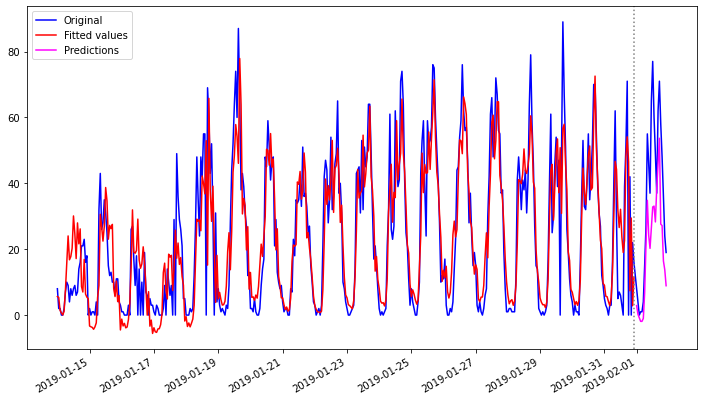

In [61]:
n_predicted_hours = 24 * 1
predicted_values = results_ARMA.predict(
    start=len(demand_train) + 1,
    end=len(demand_train) + n_predicted_hours - 1,
    dynamic=False,
)

fig = plt.figure(figsize=(12, 7))


fitted_values = results_ARMA.fittedvalues
demand = pd.concat([demand_train, demand_test], axis=0)
plt.plot(demand[demand.index.isocalendar().week > 2], label="Original", color="blue")
plt.plot(
    fitted_values[fitted_values.index.isocalendar().week > 2],
    label="Fitted values",
    color="red",
)
plt.plot(predicted_values, label="Predictions", color="magenta")
plt.legend()
fig.autofmt_xdate()
plt.axvline(x=demand_train.index[-1], color="gray", linestyle="dotted")

plt.show()


In [63]:
predicted_values = predicted_values[demand_test.index] # demand train is incomplete

train_mse = mean_squared_error(demand_train, fitted_values)
train_mae = mean_absolute_error(demand_train, fitted_values)

test_mse = mean_squared_error(demand_test, predicted_values)
test_mae = mean_absolute_error(demand_test, predicted_values)

# make dataframe with results
results = pd.DataFrame(
	{
		"mse": [train_mse, test_mse],
		"mae": [train_mae, test_mae],
	},
	index=["Train", "Test"],
)
results

,mse,mae
Train,134.376734,8.242633
Test,365.879494,14.969656
